## MMFlow Tutorial

In this tutorial, we will compute the absolute free energy of methyl hexanoate in implicit solvent using FastMBAR and MMFlow. 

MD simulation gives us a set of possible configurations of a state (trajectory). We can visualize the simulated configurations as below.  

In [30]:
import nglview as nv
import mdtraj

In [31]:
mol_id = "mobley_1017962"
topology = mdtraj.load_prmtop(f"./structure/{mol_id}.prmtop")
traj = mdtraj.load_dcd(f"./output/OBC2/traj/traj_md.dcd", topology)

In [32]:
m_view = nv.show_mdtraj(traj)
m_view

NGLWidget(max_frame=9999)

### Absolute free energy calculation using a learned reference state

Let us name this state $A$. To compute the absolute free energy of the state ($F_A$), we will define the reference state $\mathring{A}$. If $A$ and $\mathring{A}$ have a good overlap in their configuration space, we can use Bennett acceptance ratio (BAR) equation to compute the difference between the relative free energies of the two states ($\Delta F$).  

#### BAR equation for $A$ and $\mathring{A}$   

$$\sum^{N_A}_{k=1} f(\beta [\Delta U(x^A_k) - M - \Delta F]) = \sum^{N_\mathring{A}}_{k=1} f(-\beta [\Delta U(x^\mathring{A}_k) - M - \Delta F])$$  
where $f(t) = 1 / (1+\exp(t))$, $M = \ln (N_\mathring{A} / N_A)$, and $x^A_k$, $x^\mathring{A}_k$ being configuration samples from two states.

For our target state $A$, we can sample $x_k^A$ with MD simulations. **Our assumption** is that if we can learn a tractable generative model $q_\theta(x)$ that maximizes the likelihood of observing $x_k^A$, this generative model would define a new equilibrium state **$\mathring{A}$**, which would be **an excellent reference state for $A$**. This is because the overlap between two states is guaranteed as generative model resembles $p_A(x)$. 

$\Delta U$ is a difference potential observed while sampling state $A$ and $\mathring{A}$.  
$$\Delta U(x) = U_A(x) - U_\mathring{A}(x)$$
Here, $U_A$ and $U_\mathring{A}$ are the potential functions when the system is in state $A$ and $\mathring{A}$, respectively.  

From the Boltzmann distribution equation,  
$$U_A(x) = - (1/\beta)\log p_A(x)$$
$$U_\mathring{A}(x) = - (1/\beta)\log q_\theta(x)$$ 
**Since we need $\Delta U(x^A_k)$ and $\Delta U(x^\mathring{A}_k)$ to compute BAR equation, we will compute $\log p_A(x)$ and $\log q_\theta(x)$ for both $x^A_k$ (samples from MD simulation) and $x^\mathring{A}_k$ (samples from MMFlow).** 

Importantly, since the partition function $Z_\mathring{A}$ of the state $\mathring{A}$ is equal to 1, the free energy of $\mathring{A}$ would be $F_\mathring{A} = – (1/\beta)\log Z_\mathring{A} = 0$. As a result, 
$$\Delta F = F_A - F_\mathring{A} = F_A$$
In other words, we can obtain the absolute free energy of the state A $F_A$ by solving BAR equation using $\mathring{A}$ as a reference state.

### Python library imports, system configuration, model loading

In [7]:
import os
import time
import sys
from sys import stdout, exit
import math
from collections import defaultdict

import numpy as np
import pickle
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR, ReduceLROnPlateau
import torch.distributions as distributions
torch.set_default_dtype(torch.float64)

import mdtraj
import simtk.openmm as omm
import simtk.openmm.app as app
import simtk.unit as unit

import MMFlow
from MMFlow import transform, MMFlow, utils
from script.functions import *

sys.path.append("../../")
sys.path.append("./script/")

In [8]:
# Load molecular structure from prmtop and inpcrd file
mol_id = "mobley_1017962"
prmtop = app.AmberPrmtopFile(f"./structure/{mol_id}.prmtop")
inpcrd = app.AmberInpcrdFile(f"./structure/{mol_id}.inpcrd")
solvent = 'OBC2'

# Configure environments 
# such as 'Solvent=None' (for vacuum) or 'Solvent=app.OBC2'. 
system = prmtop.createSystem(nonbondedMethod=app.NoCutoff,
                             rigidWater=False,
                             implicitSolvent=app.OBC2,
                             removeCMMotion=True) 

# Write system file
with open(f"./structure/{mol_id}_{solvent}.xml", 'w') as file_handle:
    file_handle.write(omm.XmlSerializer.serializeSystem(system))

/home/soojungy/anaconda3/envs/mmflow2/lib/python3.8/site-packages/openmm/app/internal/amber_file_parser.py:1102: UserWarning: Non-optimal GB parameters detected for GB model OBC2
  warnings.warn(


In [7]:
# Load a mmflow model trained with configurations 
num_transforms = 20
hidden_size = 16
data = torch.load(f"./output/{solvent}/mmflow_models_hidden_size_{hidden_size}_num_transforms_{num_transforms}/mmflow_model.pt")

conditioner_net_create_fn = lambda feature_size, context_size, output_size: \
    transform.ResidualNet(feature_size,
                          context_size,
                          output_size,
                          hidden_size = data['hidden_size'],
                          num_blocks = data['num_blocks'])

mmflow = MMFlow(data['feature_size'],
                data['context_size'],
                data['circular_feature_flag'],
                data['transform_feature_flag'],
                conditioner_net_create_fn,
                num_bins_circular = data['num_bins_circular'],
                num_bins_regular = data['num_bins_regular'])

mmflow.load_state_dict(data['state_dict'])

device = torch.device("cpu")    
mmflow = mmflow.to(device)

### Normalizing flow-based generative model

In [33]:
from IPython.display import Image

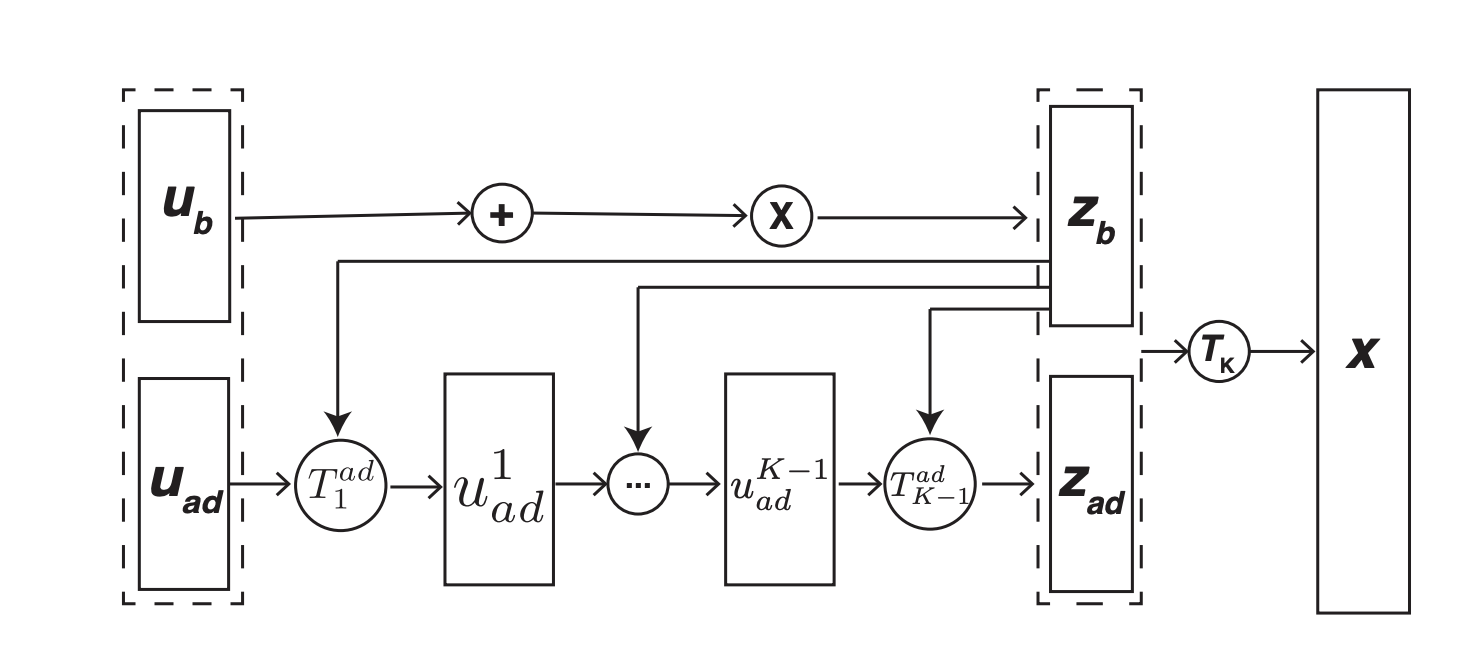

In [2]:
Image(filename='./img_tutorial/flow.png')

Above is the overall architecture of the MMFlow model. Starting from sampling the random variable $u_b$, which represents the bond length ("context") and $u_{ad}$, which represents bond angle and dihedral angle ("feature"), sequential K transformations ($T_1, \dots T_K$) gives us a configuration $x$ in Cartesian coordinate.      

$$x = T(u) = T_K \circ \dots \circ T_1(u)$$  
$$u = T^{-1}(x)$$

For the context $u_b$, we assume multivariate Gaussian distribution, where mean and variance are obtained from the statistics of the observed configurations $x^k_A$. 

For the feature $u_{ad}$, a uniform distribution over a torus where each dimension has a range of $(−\pi, \pi]$ is chosen as the base distribution.  

We apply K-1 transformations to sampled $u_{ad}$ to obtain $z_{ad}$, where $T_{i}^{ad}$ represents ith transformation. Each transformation is a rational-quadratic neural spline flows over a torus with coupling layers (RQ-NSF(C)), which is parameterized by neural network $\theta = NN(u_{ab}, z_b)$. The architecture of the flow is shown below:

In [8]:
mmflow

MMFlow(
  (transforms): ModuleList(
    (0): MixedRationalQuadraticCouplingTransform(
      (conditioner_net): ResidualNet(
        (blocks): ModuleList(
          (0): ResidualBlock(
            (linear_layers): ModuleList(
              (0): Linear(in_features=49, out_features=49, bias=True)
              (1): Linear(in_features=49, out_features=49, bias=True)
            )
          )
          (1): ResidualBlock(
            (linear_layers): ModuleList(
              (0): Linear(in_features=49, out_features=49, bias=True)
              (1): Linear(in_features=49, out_features=49, bias=True)
            )
          )
        )
        (final_layer): Linear(in_features=49, out_features=288, bias=True)
      )
    )
    (1): MixedRationalQuadraticCouplingTransform(
      (conditioner_net): ResidualNet(
        (blocks): ModuleList(
          (0): ResidualBlock(
            (linear_layers): ModuleList(
              (0): Linear(in_features=71, out_features=71, bias=True)
              

Finally, we apply $T_K$, which is a transformation from internal coordinate to Cartesian coordinate, to obtain $x$.

## Compute $\log{q_\theta}$ for A

We will first operate the potential energy function in state $\mathring{A}$ for samples in $A$. In other words, we obtain $\log q_\theta(x^A_k)$. 

$q_\theta(x)$ and the distribution of random variable $u$, $p_u(u)$, are connected as follows.

$$\log{q_\theta(x)} = \log{p_u(u)} - \sum_{k=1}^{K}{\log |J_{T_{K}}(u_{k-1})|}$$

First, we need to compute $u = T^{-1}(x^A)$. Since we saved the configurations $x^A$ as internal coordinates, the data we load is actually $z^A$. So we will map the internal coordinate $z^A$ to feature and context space of $u$ using the function **ic_to_feature_and_context**.

In [11]:
# Load MD samples and data
data = torch.load(f"./output/{solvent}/ic_md_second_half.pt")
ic_md = data['ic_md']
ic_md_logabsdet = data['ic_md_logabsdet']
ic_md_limits = torch.load(f"./output/{solvent}/ic_md_limits.pt")

# Transform internal coordinate to feature and context
with open(f"./output/{solvent}/coordinate_transformer.pkl", 'rb') as file_handle:
    coor_transformer = pickle.load(file_handle)
circular_feature_flag, feature_md, context_md, logabsdet_jacobian = ic_to_feature_and_context(ic_md, ic_md_limits)

In [8]:
feature_size = feature_md.shape[-1]
context_size = context_md.shape[-1]

feature_md = feature_md.double()
context_md = context_md.double()

We will compute the total $\log{p_u}$ as follows:
$$ \log{p_u(u)} = \log{p_{u_{b}}(u_b)} + \log{p_{u_{ad}}(u_{ad}|{u_{b}})}$$

From the statistics (mean and covariance) of the MD samples $x^A$, we define the multivariate normal distribution as a base distribution of the random variable $u_b$, $p_{u_{b}}$. 

In [9]:
context_mean = torch.mean(context_md, 0)
context_centered = context_md - context_mean[None, :]
context_cov = torch.matmul(context_centered.T, context_centered) / context_md.shape[0]
context_dist = distributions.MultivariateNormal(loc = context_mean,
                                                covariance_matrix = context_cov)

We first compute $\log{p_{u_{b}}(u_b^A)}$ from the base distribution and observation $u_b^A$.

In [10]:
log_q_context_md = context_dist.log_prob(context_md)

Then, we compute $\log{p_{u_{ad}}(u_{ad}|{u_{b}})}$ from the observation $u_b^A$ and $u_{ad}^A$. 

In [12]:
batch_size = 1024
log_q_feature_md = []
for idx_batch in range(feature_md.shape[0]//batch_size + 1):
    print(f"idx_batch: {idx_batch}")
    with torch.no_grad():
        batch_context_md = context_md[idx_batch*batch_size:(idx_batch+1)*batch_size].to(device)
        batch_feature_md = feature_md[idx_batch*batch_size:(idx_batch+1)*batch_size].to(device)
        log_prob = mmflow.compute_log_prob(batch_feature_md, batch_context_md)
    log_prob = torch.squeeze(log_prob)
    log_q_feature_md.append(log_prob.cpu())
    
log_q_feature_md = torch.cat(log_q_feature_md, 0)

idx_batch: 0
idx_batch: 1
idx_batch: 2
idx_batch: 3
idx_batch: 4


Now that we computed $\log p$, we need the value of $\sum_{k=1}^{K}{\log |J_{T_{K}}(u_{k-1})|}$. **ic_md_logabsdet** is a Jacobian of transformation from xyz coordinate to internal coordinate ($T_K^{-1}$) and **logabsdet_jacobian** is a Jacobian of transformation from the internal coordinate to feature and context ($T_{1\circ \dots \circ K-1}^{-1}$). 

To compute the Jacobian of inverse transformation we multiply the Jacobian by $-1$. Thus, to obtain $\log{q_\theta(x)}$, we substract $-\log{J_{T_K}^{-1}} + -\log{J_{T_{1\circ \dots \circ K-1}}^{-1}}$ from $\log{p_u(u)}$, which would be identical to adding two values.

In [ ]:
log_q_md = log_q_context_md + log_q_feature_md + (ic_md_logabsdet + logabsdet_jacobian)

## Compute $\log{q_\theta}$ for $\mathring{A}$ 

We now operate the potential energy function in state $\mathring{A}$ for samples in the reference state $\mathring{A}$. In other words, we obtain $\log q_\theta(x^\mathring{A}_k)$. We will first sample the configurations $x^\mathring{A}_k$ from the generative model, then retrieve their log probability. 
$$x \sim q_\theta(x) = T(u \sim p_u(u))$$

Same as before, the total $\log{p_u}$ is computed as follows:  
$$ \log{p_u(u)} = \log{p_{u_{b}}(u_b)} + \log{p_{u_{ad}}(u_{ad}|{u_{b}})}$$ 

First, we sample $u_b$ from the base distribution, and compute $p_{u_b}(u_b)$. 

In [13]:
num_samples = len(ic_md)
context_flow = context_dist.sample((num_samples,))
log_q_context_flow = context_dist.log_prob(context_flow)

Then, we sample $u_{ad}$ from the base distribution, and compute $p_{u_{ad}}(u_{ad}|u_b)$. 

In [14]:
batch_size = 1024

feature_flow_list = []
log_q_feature_flow = []
for idx_batch in range(num_samples//batch_size + 1):
    print(f"idx_batch: {idx_batch}")
    with torch.no_grad():
        batch_context_flow = context_flow[idx_batch*batch_size:(idx_batch+1)*batch_size]
        feature_flow, log_prob = mmflow.sample_and_compute_log_prob(1, batch_context_flow.to(device))        
    feature_flow = torch.squeeze(feature_flow)
    feature_flow_list.append(feature_flow.cpu())
    log_prob = torch.squeeze(log_prob)
    log_q_feature_flow.append(log_prob.cpu())
feature_flow = torch.cat(feature_flow_list, 0)
log_q_feature_flow = torch.cat(log_q_feature_flow, 0)

idx_batch: 0
idx_batch: 1
idx_batch: 2
idx_batch: 3
idx_batch: 4


Now we convert $u$ to $z = T_{1\circ \dots \circ K-1}(u)$, and then convert $z$ to $x = T_K(z)$. We also get Jacobians for $T_{1\circ \dots \circ K-1}(u)$ (**logabsdet_jacobian_flow**) and $T_K$ (**logabsdet_jacobian_flow_ic**). 

In [22]:
ic_flow, logabsdet_jacobian_flow = feature_and_context_to_ic(feature_flow, context_flow, ic_md_limits)

In [23]:
guest_xyz_flow, logabsdet_jacobian_flow_ic = coor_transformer.compute_xyz_from_internal_coordinate(
    ic_flow.reference_particle_1_xyz,
    ic_flow.reference_particle_2_bond,
    ic_flow.reference_particle_3_bond,
    ic_flow.reference_particle_3_angle,
    ic_flow.bond,
    ic_flow.angle,
    ic_flow.dihedral
)

We finally compute $\log{q_\theta(x)} = \log{p_u(u)} - \sum_{k=1}^{K}{\log |J_{T_{K}}(u_{k-1})|}$

In [36]:
log_q_flow = log_q_context_flow + log_q_feature_flow - (logabsdet_jacobian_flow + logabsdet_jacobian_flow_ic)

## Compute log $p_A$ for $A$ and $\mathring{A}$

We now operate the potential energy function in state $A$ for samples in $A$ and $\mathring{A}$. In other words, we will compute $\log p_A(x^A)$ and $\log p_A(x^\mathring{A})$ from the Boltzmann distribution.

In [17]:
T = 300 * unit.kelvin
integrator = omm.LangevinIntegrator(T,
                                    1/unit.picosecond,
                                    1*unit.femtosecond)
platform = omm.Platform.getPlatformByName("Reference")
omm_context = omm.Context(system, integrator, platform)
kbT = unit.BOLTZMANN_CONSTANT_kB * T * unit.AVOGADRO_CONSTANT_NA

Load configurations sampled from MD simulations ($x^A_k$)

In [ ]:
topology = mdtraj.load_prmtop(f"./structure/{mol_id}.prmtop")
traj = mdtraj.load_dcd(f"./output/{solvent}/traj/traj_md.dcd",
                       top = topology, stride = 1)
xyz = traj.xyz
# Use first 5,000 samples
xyz = xyz[xyz.shape[0]//2:]

Load configurations sampled from MMFlow ($x_k^\mathring{A}$)

In [ ]:
traj_flow = mdtraj.load_dcd(f"./output/{solvent}/traj/traj_flow_hidden_size_{hidden_size}_num_transforms_{num_transforms}.dcd",
                       top = topology, bstride = 1)
xyz_flow = traj_flow.xyz

Calculate potential energy from the configuration and compute $\log p_A(x) = - \beta U(x)$. 

In [18]:
# MD samples 
log_p_md = []
for i in range(xyz.shape[0]):        
    omm_context.setPositions(xyz[i])
    state = omm_context.getState(getEnergy = True)
    u = state.getPotentialEnergy()
    log_p_md.append(-u/kbT)
log_p_md = np.array(log_p_md)

In [19]:
# MMFlow samples
log_p_flow = []    
for i in range(xyz_flow.shape[0]):         
    omm_context.setPositions(xyz_flow[i])
    state = omm_context.getState(getEnergy = True)
    u = state.getPotentialEnergy()
    log_p_flow.append(-u/kbT)
log_p_flow = np.array(log_p_flow)

### Compute Free energy using FastMBAR

Now we have all the necessary values, we use FastMBAR, which is an extremely fast Python solver for large scale MBAR equations. In this case, FastMBAR takes reduced potential energy matrix as an input.  

In [20]:
from FastMBAR import FastMBAR

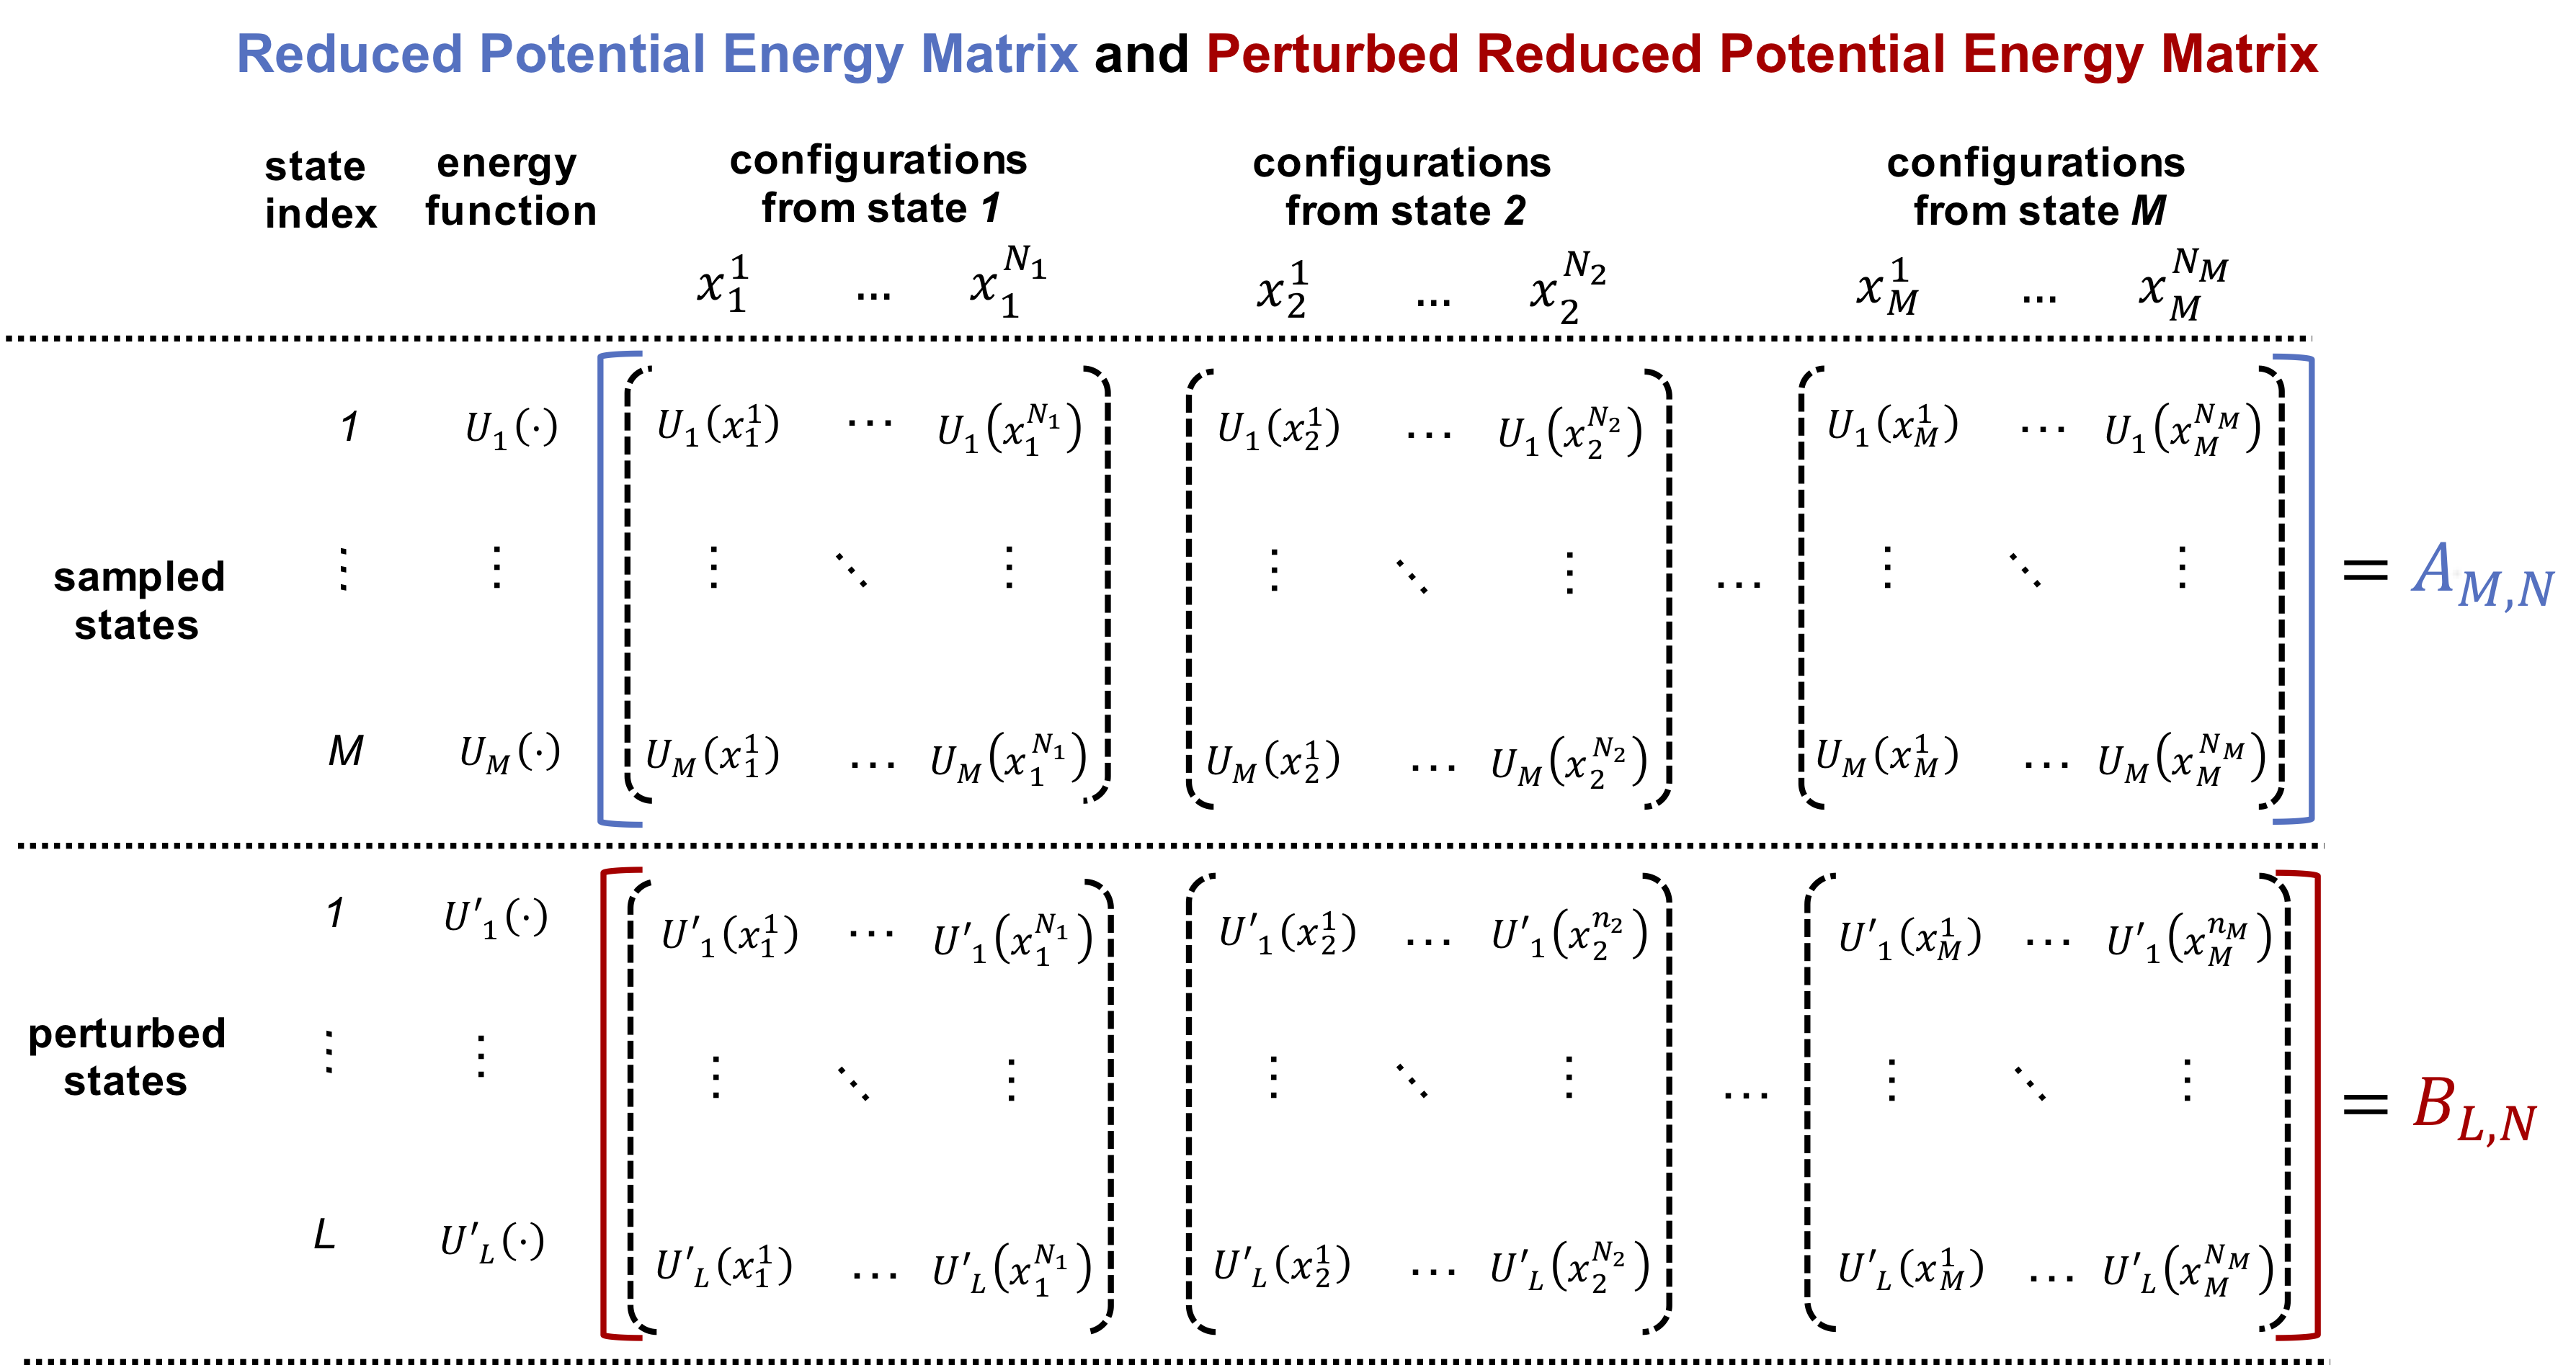

In [6]:
Image(filename='./img_tutorial/energy_matrix.png')

We will construct the reduced potential energy matrix where the number of state = 2. State 1 would be $\mathring{A}$ and state 2 would be $A$. Our energy matrix is easily constructed as below:

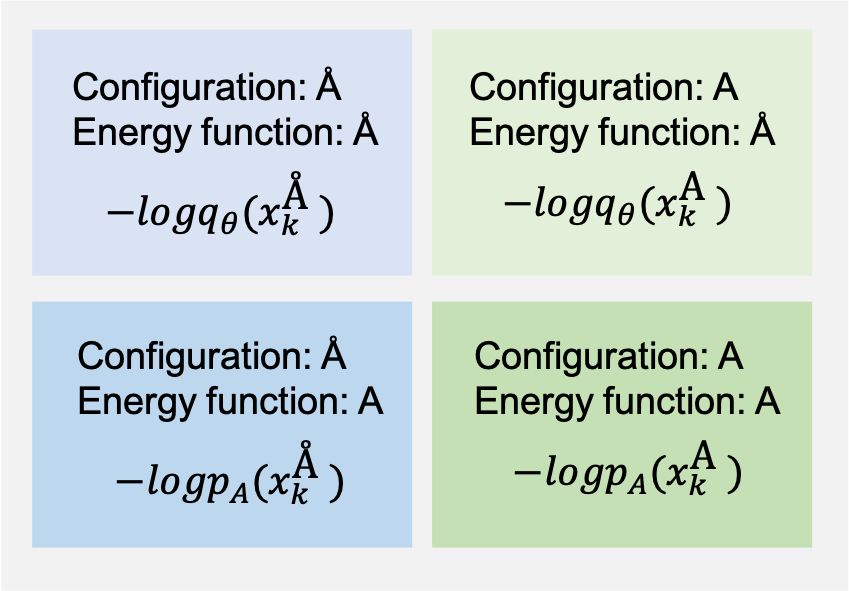

In [37]:
Image(filename='./img_tutorial/mbar_matrix.png', width=400)

In [37]:
energy_matrix = np.zeros((2, len(log_q_flow) + len(log_q_md)))
energy_matrix[0, 0:len(log_q_flow)] = -log_q_flow
energy_matrix[0, len(log_q_flow):] = -log_q_md

energy_matrix[1, 0:len(log_p_flow)] = -log_p_flow
energy_matrix[1, len(log_p_flow):] = -log_p_md

num_conf = np.array([len(log_q_flow), len(log_q_md)])
fastmbar = FastMBAR(energy_matrix, num_conf, verbose = True)

solve MBAR equation using CPU


FastMBAR gives us the relative free energy of two states are stored in fastmbar.F. We can confirm that the relative free energy of $\mathring{A}$ is equal to zero, while the relative free energy of $A$ is equal to 230.0831931. By substracting two values, we obtain $F_A = 230.0831931$. 

In [38]:
# FastMBAR
fastmbar.F[-1]

array([  0.       , 230.0831931])

If we compute the absolute free energy of methyl hexanoate in vacuum, we get 236.12185961. By substracting two values, we get -6.038666510000013 of free energy difference. This is **a very similar value** to -6.06200626, which is the solvation energy value computed with traditional approach. Thus, DeepBAR has a good accuracy on our methyl hexanoate example. 